### Experiment with Copia module: book genres
This notebook explores the data on the survival of poetic books (1834-1850) stored in 10 library collections; books are manually provided with general genre tags, the groups are:
- col_lyr: poetry collections of lyrical texts (short poems);
- col_nar: colletcions of narrative poems (~epic poetry);
- sep_lyr: separate issues of one lyrical text (one-two pages brochures with a single poem);
- sep_nar: separate issues of one narrative poem;
- sep_drama: separate issue of a dramatic text in verse;
- alm_ : almanacs and collective issues (may also include prose);

#### Part I: Tests for each book genre for the whole period (1834-1850)

In [1]:
import os
import glob

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
np.random.seed(1234)

In [2]:
import copia.utils as u
from copia.richness import *

from copia.utils import survival_ratio
from copia.utils import to_abundance, basic_stats

from copia.richness import species_accumulation

from copia.plot import abundance_histogram, accumulation_curve, multi_kde, survival_errorbar

In [3]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.minor.left'] = False

In [4]:
groups = {}
df = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/*.csv')):
    df = pd.read_csv(fh)
    df = df.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('_', ' ')
    groups[genre] = df[['work', 'collection']]

In [6]:
groups

{'Almanacs':                                                   work collection
 0    1834_43_Фл… Спин.._Незабудка: Московский Альма...        nlr
 1    1834_43_Фл… Спин.._Незабудка: Московский Альма...        rsl
 2    1834_43_Фл… Спин.._Незабудка: Московский Альма...      fi_sl
 3    1834_47_Максимович М._Денница: Альманах на 183...        nlr
 4    1834_47_Максимович М._Денница: Альманах на 183...      fi_sl
 ..                                                 ...        ...
 303  1830_981_NA_Чертополох, карманная книжица для ...        nlr
 304  1830_981_NA_Чертополох, карманная книжица для ...        rsl
 305  1830_981_NA_Чертополох, карманная книжица для ...      spbgu
 306  1830_1027_NA_Старинные диковинки, или собрание...        nlr
 307  1830_1027_NA_Старинные диковинки, или собрание...      fi_sl
 
 [308 rows x 2 columns],
 'Collections lyric':                                                   work  collection
 0    1834_2_Батюшков К._Сочинения в прозе и стихах ...         nlr


In [7]:
# Basic stats calculation

stats = []

for genre, df in groups.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'Group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['Collections'] = len(set(df['collection']))
    stats.append(d)
    
# Conversion to df for easier use
stats_df = pd.DataFrame(stats)
stats_df

,Group,f1,f2,f3,f4,S,n,Collections
0,Almanacs,6,26,41,16,101,308,9
1,Collections lyric,64,68,57,54,313,1000,11
2,Collections narrative,2,5,2,8,27,108,10
3,Separate lyric,188,56,15,8,269,387,11
4,Separate narrative,69,72,60,31,257,659,11


Almanacs
Collections lyric
Collections narrative
Separate lyric
Separate narrative


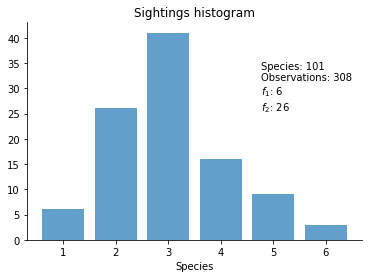

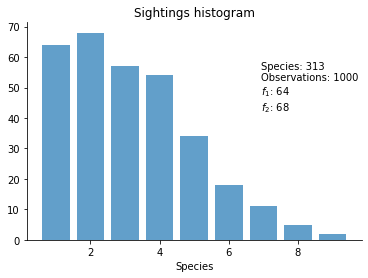

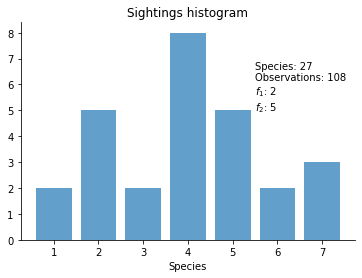

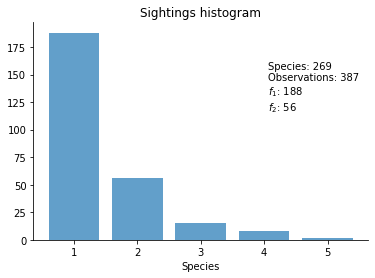

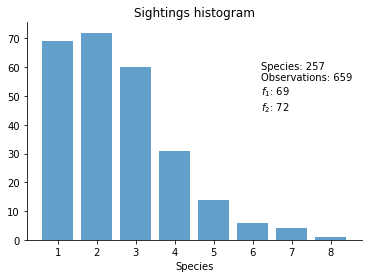

In [11]:
# fast viz: sightings hist

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    print(genre)
    abundance_histogram(abundance)

In [8]:
# Estimations for original works with different estimators

estimation_dict = {}

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    estimation_dict[genre.title()] = abundance

for genre, population in estimation_dict.items():
    print('genre:', genre)
    for m in ('chao1', 'ichao1', 'egghe_proot'):
        print(' - ', m, '->', diversity(population, method = m))

genre: Almanacs
 -  chao1 -> 101.69005994005994
 -  ichao1 -> 101.69005994005994
 -  egghe_proot -> 101.02095891738362
genre: Collections Lyric
 -  chao1 -> 343.0875294117647
 -  ichao1 -> 350.5057392883079
 -  egghe_proot -> 355.4937603040866
genre: Collections Narrative
 -  chao1 -> 27.396296296296295
 -  ichao1 -> 27.482233796296295
 -  egghe_proot -> 27.19243329141031
genre: Separate Lyric
 -  chao1 -> 583.7559985234404
 -  ichao1 -> 647.2716235234404
 -  egghe_proot -> 597.2595412883953
genre: Separate Narrative
 -  chao1 -> 290.01232928679815
 -  ichao1 -> 290.01232928679815
 -  egghe_proot -> 293.4242222910879


In [15]:
# Minimum additional sample (lower bound on the true population size)

for genre, population in estimation_dict.items():
    print('genre:', genre)
    print(' - works : ', diversity(population, method = 'ichao1')) # ichao1 for taking into acc. f3 & f4
    print(' - documents : ', diversity(population, method = 'minsample'))

genre: Almanacs
 - works :  101.69005994005994
 - documents :  406.12889812889813
genre: Collections Lyric
 - works :  350.5057392883079
 - documents :  3927.002927002927
genre: Collections Narrative
 - works :  27.482233796296295
 - documents :  144.1908361908362
genre: Separate Lyric
 - works :  647.2716235234404
 - documents :  6021.919134919135
genre: Separate Narrative
 - works :  290.01232928679815
 - documents :  2654.915295915296


In [16]:
# Survival ratios on density plot: works

works_survival = {}
for genre, population in estimation_dict.items():
    works_survival[genre] = survival_ratio(population, method = 'ichao1')

  0%|                                          | 1/1000 [00:01<17:30,  1.05s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 806.76it/s]


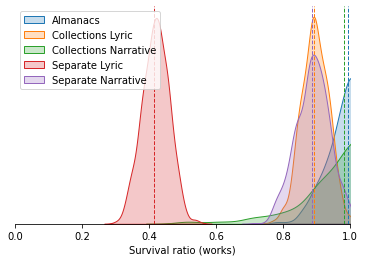

In [18]:
surv_density_works = multi_kde(works_survival)
surv_density_works.set_xlabel('Survival ratio (works)')
surv_density_works.set_yticklabels([])
surv_density_works.tick_params(axis = 'y', which = 'both', left = False)
surv_density_works.spines['left'].set_visible(False)

#plt.savefig(".../plots/02_work_surv_density.pdf")

### Accumulation curves
- Lowest survival: 
    - Separate lyric poems
    - Separate narrative poems
    - Collections of lyric poems

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


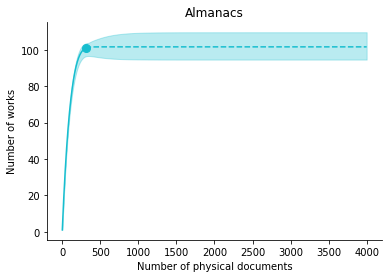

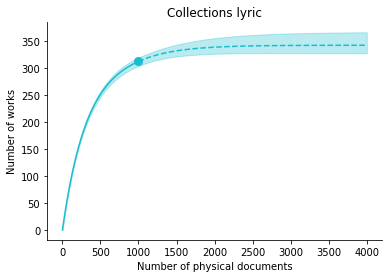

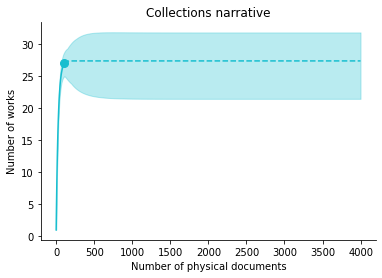

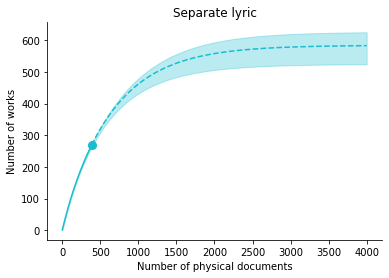

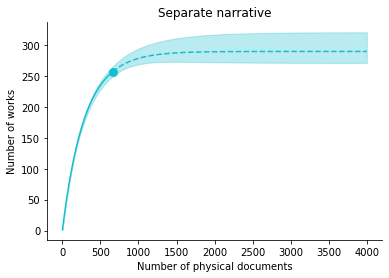

In [14]:
# accumulation curves

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    accumulation = species_accumulation(abundance, max_steps = 4000, n_iter = 10)
    accumulation_curve(abundance, accumulation, 
                       xlabel = 'Number of physical documents', ylabel = 'Number of works',
                       title = genre, 
                      c0 = 'C9')
    #plt_name = '.../plots/02_'+genre+'.png'
    #plt.savefig(plt_name)

#### Comparison of different estimators (works)

In [44]:
comp = []

for estim in ['chao1', 'ichao1', 'egghe_proot']:
    for genre, population in estimation_dict.items():
        surv = survival_ratio(population, method = estim, n_iter = 1000)
        comp.append([genre, estim, surv['survival'], surv['lci'], surv['uci']])

  0%|                                          | 1/1000 [00:01<17:51,  1.07s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:34,  1.06s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:31,  1.05s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 830.13it/s]


In [45]:
comp_df = pd.DataFrame(comp, columns = ['genre', 'estimator', 'survival_ratio', 'lower_ci', 'upper_ci'])

estimates = comp_df.sort_values(['genre', 'estimator'])
estimates.head()

,genre,estimator,survival_ratio,lower_ci,upper_ci
0,Almanacs,chao1,0.993214,0.895177,1.077972
10,Almanacs,egghe_proot,0.999793,0.792297,1.151358
5,Almanacs,ichao1,0.993214,0.867575,1.091700
1,Collections Lyric,chao1,0.912304,0.844749,0.981466
11,Collections Lyric,egghe_proot,0.880466,0.767207,0.993473


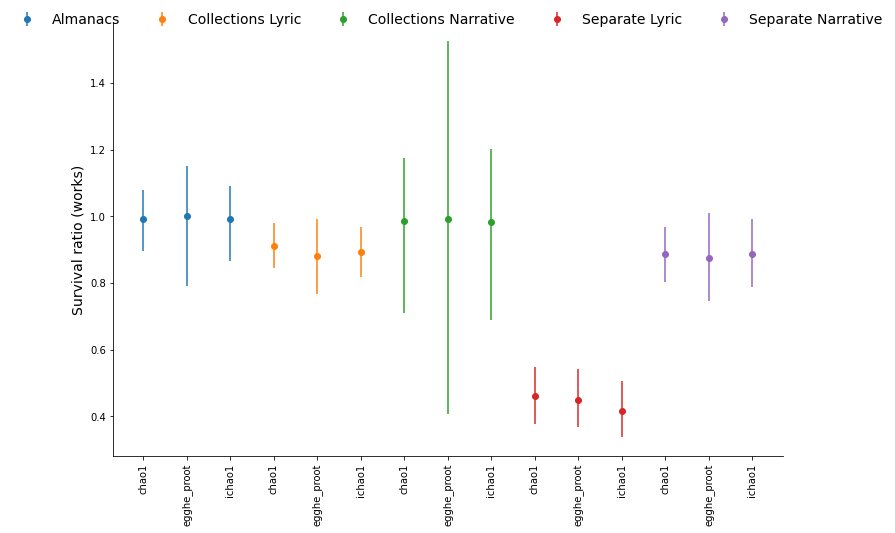

In [47]:
errors = np.array(list(zip(estimates['lower_ci'], estimates['upper_ci']))).T
errors[0] = estimates['survival_ratio'] - errors[0]
errors[1] -= estimates['survival_ratio']

fig, ax = plt.subplots(figsize=(12, 8))

genres = sorted(set(estimates['genre']))
color_dict = {t: f"C{i}" for i, t in enumerate(genres)}
labeled = {t:False for t in color_dict}

for idx in range(len(estimates)):
    genre = estimates['genre'].iloc[idx]
    meth = estimates['estimator'].iloc[idx]
    label = genre if not labeled[genre] else None
    c = color_dict[genre]
    labeled[genre] = True
    ax.errorbar(idx, estimates['survival_ratio'].iloc[idx],
        yerr=np.array([errors[:, idx]]).T,
        fmt='.', c=color_dict[genre], label=label,
        ms=12)

ax.set_ylabel('Survival ratio (works)', fontsize=14)
ax.set_xticks(np.arange(len(estimates)))
ax.set_xticklabels(estimates['estimator'], rotation = 90)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=True)
ax.legend(loc='upper center', ncol=len(estimation_dict), bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)

#plt.savefig("/Users/tonya/Documents/thesis1830s/22_02_poetry_collections_biblio/github_main/plots/02_methods_comparison.pdf")

### Fast test: time differences for genres

In [68]:
groups_t = {}
df_t = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/addition/*.csv')):
    df_t = pd.read_csv(fh)
    df_t = df_t.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('exp_','').lower()
    groups_t[genre] = df_t[['work', 'collection']]

In [69]:
groups_t

{'almanac_1830':                                                   work collection
 0    43_Фл… Спин.._Незабудка: Московский Альманах. ...        nlr
 1    43_Фл… Спин.._Незабудка: Московский Альманах. ...        rsl
 2    43_Фл… Спин.._Незабудка: Московский Альманах. ...      fi_sl
 3       47_Максимович М._Денница: Альманах на 1834 год        nlr
 4       47_Максимович М._Денница: Альманах на 1834 год      fi_sl
 ..                                                 ...        ...
 117  981_NA_Чертополох, карманная книжица для любит...        nlr
 118  981_NA_Чертополох, карманная книжица для любит...        rsl
 119  981_NA_Чертополох, карманная книжица для любит...      spbgu
 120  1027_NA_Старинные диковинки, или собрание прос...        nlr
 121  1027_NA_Старинные диковинки, или собрание прос...      fi_sl
 
 [122 rows x 2 columns],
 'almanac_1835':                                                  work  collection
 0   97_NA_Весенние цветы, или Собрание романсов, б...         nlr
 1 

In [70]:
# Basic stats calculation

stats_t = []

for genre, df in groups_t.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['lib'] = len(set(df['collection']))
    stats_t.append(d)
    
# Conversion to df for easier use
stats_t_df = pd.DataFrame(stats_t)
stats_t_df

,group,f1,f2,f3,f4,S,n,lib
0,almanac_1830,3,14,20,4,44,122,7
1,almanac_1835,0,5,5,7,18,59,7
2,almanac_1840,2,3,7,0,20,71,8
3,almanac_1845,1,4,9,5,19,56,6
4,col_lyr_1830,9,19,15,17,85,321,11
5,col_lyr_1835,19,22,13,10,90,293,11
6,col_lyr_1840,15,14,9,13,66,201,10
7,col_lyr_1845,21,13,20,14,72,185,8
8,col_nar_1830,1,1,1,2,7,26,9
9,col_nar_1835,1,1,1,3,14,64,10


In [71]:
populations_t = {}

for genre, df in groups_t.items():
    abundance = u.to_abundance(df_t['work'])
    populations_t[genre.title()] = abundance
    
wsurvival_t = {}

for genre, population in populations_t.items():
    wsurvival_t[genre] = survival_ratio(population, method = 'chao1')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 832.23it/s]


In [ ]:
#keys = {'Almanac_1830', 'Almanac_1835', 'Almanac_1840', 'Almanac_1840'}
keys = {'Sep_Nar_1830', 'Sep_Nar_1835', 'Sep_Nar_1840', 'Sep_Nar_1845',
       'Col_Lyr_1830', 'Col_Lyr_1835', 'Col_Lyr_1840', 'Col_Lyr_1845'}

wt = [wsurvival_t]

l = [{k:v for k, v in i.items() if k in keys} for i in wt]
l = l[0]

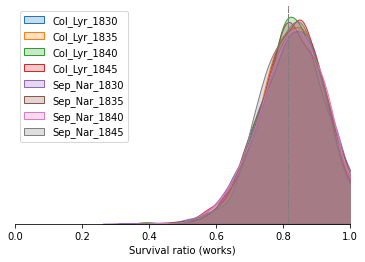

In [74]:
surv_density_w_t = multi_kde(l)
surv_density_w_t.set_xlabel('Survival ratio (works)')
surv_density_w_t.set_yticklabels([])
surv_density_w_t.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w_t.spines['left'].set_visible(False)

# plt.savefig("/Users/tonya/Documents/thesis1830s/22_02_poetry_collections_biblio/github_main/plots/02_work_surv_density_periods.pdf")